<a href="https://colab.research.google.com/github/mcatrinque/tic_tac_toe_boosting/blob/main/tic_tac_toe_boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Boosting para Classificação no Jogo da Velha

## Introdução

O processo de Boosting é uma técnica utilizada para reduzir o viés de um conjunto de modelos simples, também conhecidos como modelos fracos, através da combinação iterativa desses modelos. Os modelos fracos são levemente correlacionados com a classificação correta e são escolhidos de forma iterativa considerando viéses independentes, ou seja, cada modelo componente comete erros diferentes dos outros modelos componentes.


## Importação de Bibliotecas

In [ ]:
import pandas as pd
import numpy as np


from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve
)

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

## Visualização dos Dados

O dataset "tic-tac-toe" utilizado neste trabalho contém dados referentes ao jogo da velha, com o objetivo de prever a classificação final do jogo (vitória ou derrota). Os atributos são categóricos, representando as posições do tabuleiro e a jogada do primeiro jogador. O dataset está disponível em [Tic-Tac-Toe End Game Dataset UCI - Kaggle](https://www.kaggle.com/datasets/aungpyaeap/tictactoe-endgame-dataset-uci?datasetId=207741&searchQuery=bag).

In [ ]:
#https://drive.google.com/file/d/16_1b-g3DGHUIu0OgmwTEeRmwdaCDUWps/view?usp=sharing
!gdown --id "16_1b-g3DGHUIu0OgmwTEeRmwdaCDUWps"
tictac = pd.read_csv('tic-tac-toe-endgame.csv')
tictac.head()

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=16_1b-g3DGHUIu0OgmwTEeRmwdaCDUWps
To: /content/tic-tac-toe-endgame.csv
100% 46.0k/46.0k [00:00<00:00, 54.7MB/s]


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive


In [ ]:
tictac.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958 entries, 0 to 957
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   V1      958 non-null    object
 1   V2      958 non-null    object
 2   V3      958 non-null    object
 3   V4      958 non-null    object
 4   V5      958 non-null    object
 5   V6      958 non-null    object
 6   V7      958 non-null    object
 7   V8      958 non-null    object
 8   V9      958 non-null    object
 9   V10     958 non-null    object
dtypes: object(10)
memory usage: 75.0+ KB


In [ ]:
tictac.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10
count,958,958,958,958,958,958,958,958,958,958
unique,3,3,3,3,3,3,3,3,3,2
top,x,x,x,x,x,x,x,x,x,positive
freq,418,378,418,378,458,378,418,378,418,626


In [ ]:
tictac.isnull().sum()

V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
dtype: int64

In [ ]:
features = tictac.columns

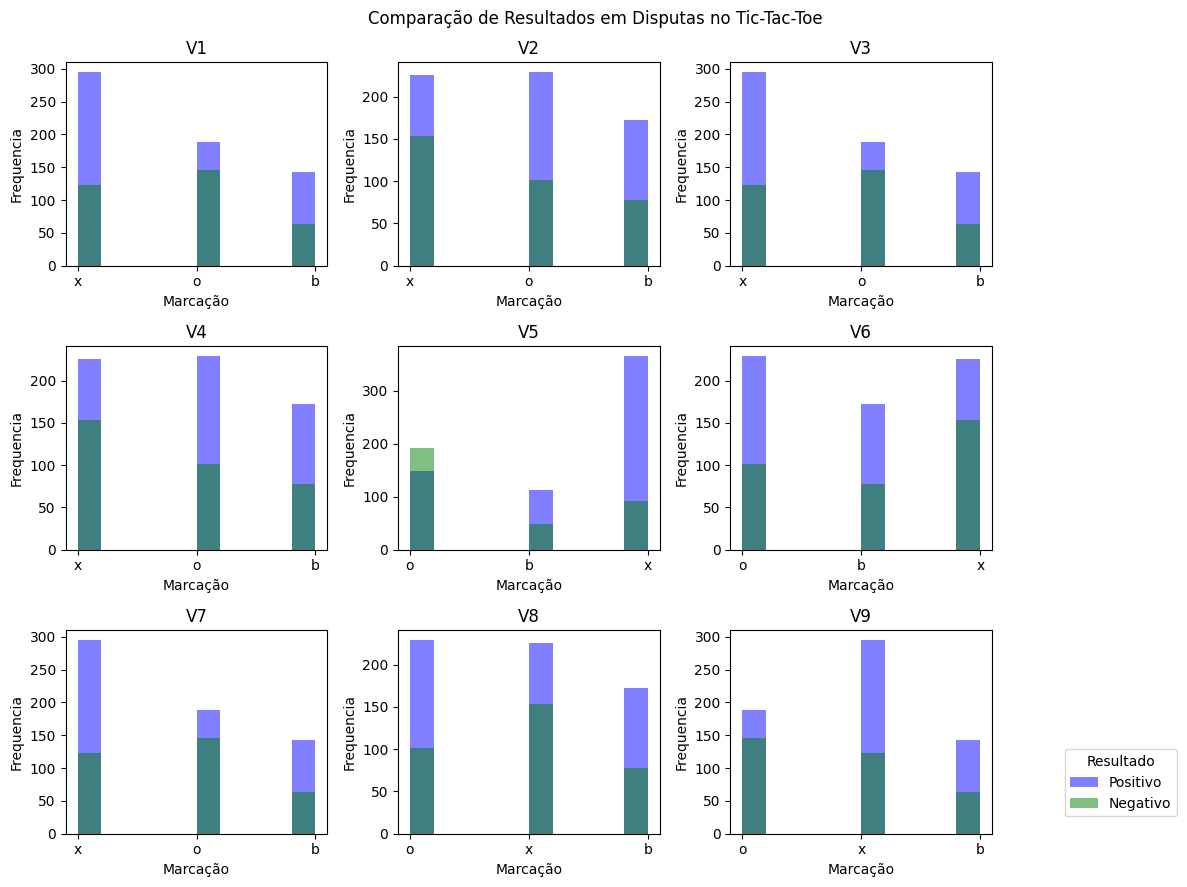

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(12, 9))
fig.suptitle('Comparação de Resultados em Disputas no Tic-Tac-Toe')

for i in range(9):
    row, features_idx = divmod(i, 3)
    ax = axes[row, features_idx]
    ax.hist(tictac[features[i]][tictac["V10"] == "positive"], bins=10, alpha=0.5, label="Positivo", color='blue')
    ax.hist(tictac[features[i]][tictac["V10"] == "negative"], bins=10, alpha=0.5, label="Negativo", color='green')
    ax.set_title(features[i])
    ax.set_xlabel("Marcação")
    ax.set_ylabel("Frequencia")
    ax.legend().remove()

plt.legend(title='Resultado', bbox_to_anchor=(1.25, 0.25), loc="center left", fontsize= 10)
plt.tight_layout()
plt.show()

## Preparação dos Dados

In [ ]:
tictac.replace('x',0,inplace=True)
tictac.replace('o',1,inplace=True)
tictac.replace('b',2,inplace=True)
tictac.replace('negative',0,inplace=True)
tictac.replace('positive',1,inplace=True)
tictac.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10
0,0,0,0,0,1,1,0,1,1,1
1,0,0,0,0,1,1,1,0,1,1
2,0,0,0,0,1,1,1,1,0,1
3,0,0,0,0,1,1,1,2,2,1
4,0,0,0,0,1,1,2,1,2,1


In [ ]:
X = tictac.iloc[:,:-1].values
y = tictac['V10'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 15)

## Treinamento dos Modelos - Decision Tree

### Seleção de Parâmetros

Uso da técnica de Grid Search para encontrar os melhores hiperparâmetros para o classificador de Árvore de Decisão.

Ela realiza uma busca exaustiva por possíveis combinações desses hiperparâmetros e avalia cada combinação usando validação cruzada. O objetivo é encontrar a combinação de hiperparâmetros que maximize o desempenho do modelo. Isso ajuda a tratar o problema de overfitting, permitindo ajustar os hiperparâmetros de acordo com os dados disponíveis.


In [ ]:
clf = DecisionTreeClassifier(criterion='entropy')
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

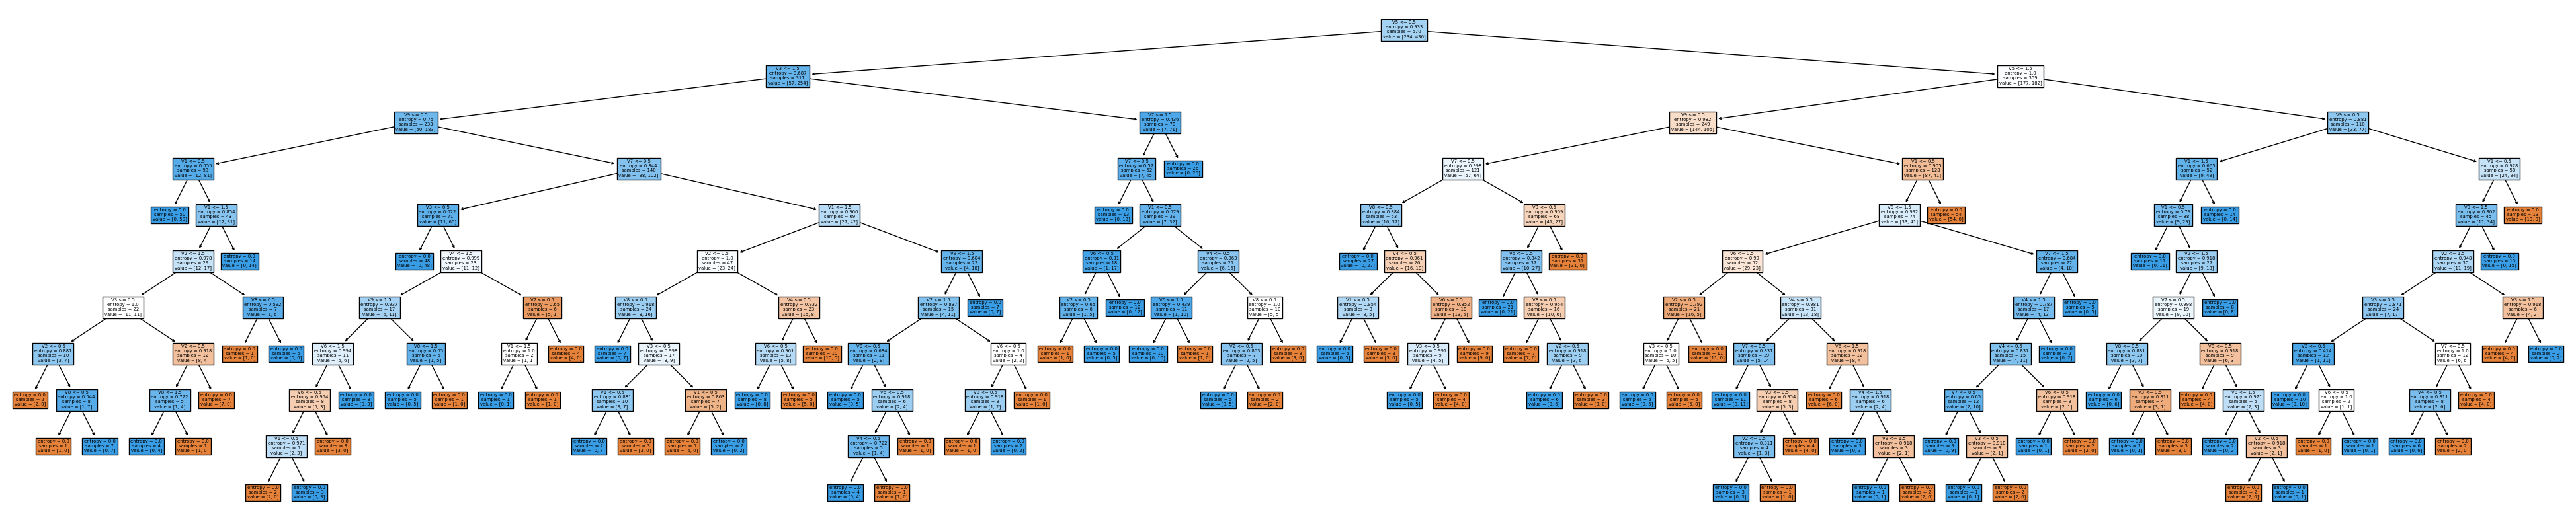

In [ ]:
fig = plt.figure(figsize=(50,10))
ax = plot_tree(clf, feature_names = features, filled=True)

In [ ]:
parameters = {
    'min_samples_split': [10, 20, 30, 40, 50],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

grid_search = GridSearchCV(clf, parameters, scoring='accuracy', cv=5)
grid_search.fit(X, y)

best_params = grid_search.best_params_
print("Parâmetros Selecionados: ", best_params)

Parâmetros Selecionados:  {'min_samples_leaf': 4, 'min_samples_split': 10}


### Modelo Simples

O algoritmo a seguir realiza a classificação do dataset "tic-tac-toe" usando um classificador de árvore de decisão, avaliando o desempenho do modelo por meio de validação cruzada com 5 partições.

O objetido do modelo é prever a classe das jogadas do jogo da velha com base nas marcações das células. A árvore de decisão busca encontrar padrões nos dados que possam indicar a melhor jogada a ser realizada em determinada situação.


#### Aplicação de Validação cruzada com 5 partições

A validação cruzada ajuda a verificar se o classificador é capaz de generalizar bem para dados não vistos anteriormente, fornecendo uma estimativa do seu desempenho em situações reais.

Durante a validação cruzada, o conjunto de dados é dividido em cinco partes diferentes, sendo que em cada iteração uma parte é utilizada como conjunto de teste e as demais como conjunto de treinamento.


In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=15)

In [ ]:
results_simple_model = pd.DataFrame(columns=['Error Rate', 'Accuracy', 'Precision', 'F1-Score', 'Recall', 'Confusion Matrix'])

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    clf = DecisionTreeClassifier(criterion='entropy', **best_params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    error_rate = 1 - accuracy
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    results_simple_model = pd.concat([
        results_simple_model,
        pd.DataFrame({
            'Error Rate': [error_rate],
            'Accuracy': [accuracy],
            'Precision': [precision],
            'Recall': [recall],
            'F1-Score': [f1],
            'Confusion Matrix': [cm]
        })
    ], ignore_index=True)

### Modelo com Boosting

O código apresentado implementa o algoritmo de Boosting, mais especificamente o AdaBoost, utilizando um conjunto de classificadores de árvore de decisão.

A execução do algoritmo abaixo pode ser dividida nos seguintes processos:

1. Inicializar o número de estimadores (árvores de decisão), taxa de aprendizado, pesos das amostras e listas para armazenar os modelos e valores de alfa.

2. Para cada iteração (número de estimadores):
   - Criar um novo estimador base (árvore de decisão) com os parâmetros especificados.
   - Treinar o estimador base usando as amostras ponderadas.
   - Fazer previsões no conjunto de treinamento.
   - Calcular a taxa de erro ponderada.
   - Calcular o valor de alfa (peso) para este estimador.
   - Atualizar os pesos das amostras.
   - Normalizar os pesos.
   - Armazenar o modelo e seu valor de alfa correspondente.

3. Após o processo de boosting, o código realiza uma validação cruzada 5-fold para avaliar o desempenho do modelo de boosting.

O uso de pesos nas amostras e a atualização iterativa desses pesos visam dar mais importância às amostras mal classificadas, permitindo que os modelos subsequentes se concentrem nos exemplos mais difíceis de classificar. Isso pode ajudar a melhorar a acurácia geral do modelo e fornecer uma melhor compreensão das jogadas no jogo da velha.

Em suma, esse processo busca melhorar o desempenho de classificação do conjunto de dados "tic-tac-toe" por meio da combinação de vários classificadores de árvore de decisão.


In [ ]:
n_estimators = 5  # Number of estimators (decision trees)
learning_rate = 0.1  # Learning rate for AdaBoost
n_samples = len(X)
weights = np.ones(n_samples) / n_samples  # Initialize sample weights
models = []  # List to store the individual models
alpha_values = []  # List to store the weights of the individual models

for _ in range(n_estimators):
    # Create a new base estimator (decision tree) with the specified parameters
    base_estimator = DecisionTreeClassifier(criterion='entropy', **best_params)

    # Train the base estimator using the weighted samples
    base_estimator.fit(X, y, sample_weight=weights)

    # Make predictions on the training set
    y_pred_boost = base_estimator.predict(X)

    # Calculate the weighted error rate
    weighted_error = np.sum(weights[y_pred_boost != y])

    # Calculate the alpha value (weight) for this estimator
    alpha = learning_rate * np.log((1 - weighted_error) / weighted_error)

    # Update the sample weights
    weights *= np.exp(alpha * (y_pred_boost != y))

    # Normalize the weights
    weights /= np.sum(weights)

    # Store the model and its corresponding alpha value
    models.append(base_estimator)
    alpha_values.append(alpha)

#### Validação cruzada com 5 partições

In [ ]:
results_boosting = pd.DataFrame(columns=['Error Rate', 'Accuracy',  'Precision', 'F1-Score', 'Recall', 'Confusion Matrix'])

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    boosted_pred = np.zeros(len(X_test))

    for model, alpha in zip(models, alpha_values):
        boosted_pred += alpha * model.predict(X_test)

    boosted_pred = np.sign(boosted_pred)
    boosted_pred[boosted_pred == -1] = 0

    accuracy = accuracy_score(y_test, boosted_pred)
    error_rate = 1 - accuracy
    precision = precision_score(y_test, boosted_pred)
    recall = recall_score(y_test, boosted_pred)
    f1 = f1_score(y_test, boosted_pred)
    cm = confusion_matrix(y_test, boosted_pred)

    results_boosting = pd.concat([
        results_boosting,
        pd.DataFrame({
            'Error Rate': [error_rate],
            'Accuracy': [accuracy],
            'Precision': [precision],
            'Recall': [recall],
            'F1-Score': [f1],
            'Confusion Matrix': [cm]
        })
    ], ignore_index=True)

## Avaliação dos Modelos

Os resultados foram avaliados a partir de diversas métricas e visualizações gráficas, com o objetivo de analisar o desempenho do modelo em diferentes partições do conjunto de dados e obter uma visão mais geral de sua eficácia.
As métricas utilizadas serão:

### Relatórios de Desempenho dos Modelos

#### Simples

In [ ]:
results_simple_model.iloc[:,:-1]

,Error Rate,Accuracy,Precision,F1-Score,Recall
0,0.187500,0.812500,0.907563,0.857143,0.812030
1,0.135417,0.864583,0.855932,0.885965,0.918182
2,0.171875,0.828125,0.821429,0.874525,0.934959
3,0.162304,0.837696,0.866667,0.883019,0.900000
4,0.225131,0.774869,0.848000,0.831373,0.815385


#### Boosting

In [ ]:
results_boosting.iloc[:,:-1]

,Error Rate,Accuracy,Precision,F1-Score,Recall
0,0.072917,0.927083,0.904762,0.950000,1.0
1,0.130208,0.869792,0.814815,0.897959,1.0
2,0.109375,0.890625,0.854167,0.921348,1.0
3,0.104712,0.895288,0.866667,0.928571,1.0
4,0.109948,0.890052,0.860927,0.925267,1.0


### Visualização da Matriz de Confusão

Comparando as matrizes de confusão do Modelo Simples e do com boosting Boosting em cada fold, podemos observar as seguintes diferenças em termos de desempenho de classificação:

*   Diagonal principal: O modelo com maior volume de previsões corretas foi o Boosting.
  * Verdadeiros Positivos (TP) - O modelo Simples obteve melhor resultado.
  * TN - Verdadeiros Negativos - O modelo com Boosting obteve melhor resultado.
* Células fora da diagonal principal: o modelo Simples apresentou o maior número de previsões incorretas.
  * FN - Falsos Negativos: O modelo com Boosting não retornou FN em nenhum dos casos.
  * FP - Falsos Positivos: Por não ter FN, todos os casos de erro do Boosting foram FPs.

Os padrões de acertos e erros para cada fold específico são evidenciados na imagem abaixo, o que nos ajuda a entender a consistência e a variabilidade do desempenho dos modelos ao longo da validação cruzada.

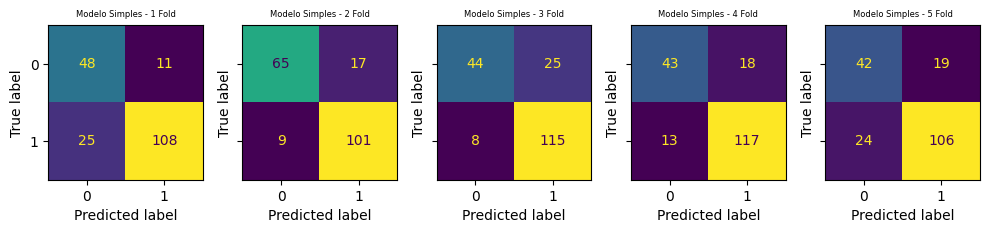

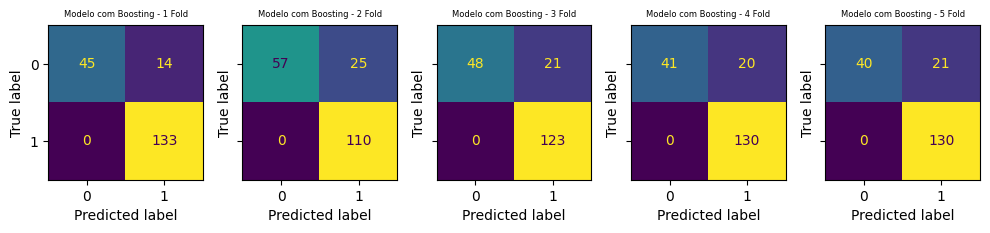

In [ ]:
def plot_confusion_matrix(result, model_name):
  f, ax = plt.subplots(1, 5, figsize=(10, 10), sharex='col', sharey='row')
  n_fold = 0
  for n_fold in range(5):
      disp = ConfusionMatrixDisplay(result['Confusion Matrix'][n_fold])
      disp.plot(ax = ax[n_fold])
      disp.ax_.set_title(f'{model_name} - {n_fold + 1} Fold', fontsize=6)
      disp.im_.colorbar.remove()
  plt.tight_layout()
  plt.show()

plot_confusion_matrix(results_simple_model, 'Modelo Simples')
plot_confusion_matrix(results_boosting, 'Modelo com Boosting')

### Desempenho das Métricas de Avaliação

Para avaliar a performance de ambos os modelos, utilizaremos as seguintes métricas de avaliação:
destacando o uso de partição na validação cruzada que obteve melhor desempenho

*   Acurácia
*   Taxa de Erro
*   Precisão
*   Revocação
*   F1-Score

As visualizações a seguir, ilustram o comportamento das métricas em relação ao modelo e ao número de partiçoes e apresentam também, os casos gerais envolvendo a média das métricas performadas pelos modelos.

Ao observar as métricas selecionadas, fica evidente que o modelo com Boosting performou melhor nos casos gerais, perdendo para o modelo Simples apenas na média de precisão.

Segue abaixo as visualizações dos principais resultados:

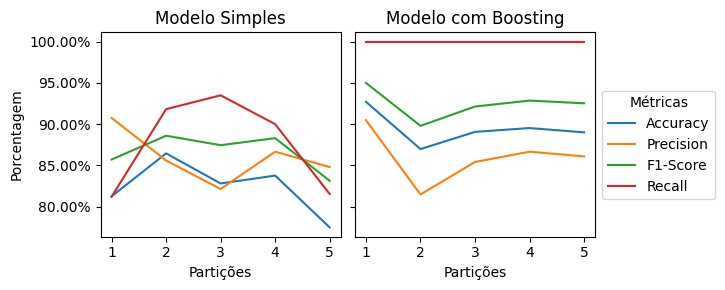

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3), sharex='col', sharey='row')

results_simple_model.iloc[:, 1:].plot(kind='line', rot=0, ax=ax[0])
results_boosting.iloc[:, 1:].plot(kind='line', rot=0, ax=ax[1])


ax[0].set_title('Modelo Simples', fontsize=12)
ax[1].set_title('Modelo com Boosting', fontsize=12)

for i in range(2):
    ax[i].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x*100:.2f}%'))
    ax[i].set_xlabel('Partições', fontsize=10)
    ax[i].set_ylabel('Porcentagem', fontsize=10)
    ax[i].legend().remove()
    ax[i].set_xticks(range(len(results_simple_model.index)))
    ax[i].set_xticklabels(results_simple_model.index + 1)


plt.tight_layout()
plt.subplots_adjust(right=0.75)

lines, labels = ax[1].get_legend_handles_labels()

fig.legend(lines, labels,title='Métricas', bbox_to_anchor=(0.75, 0.5), loc="center left", fontsize= 10)

plt.show()

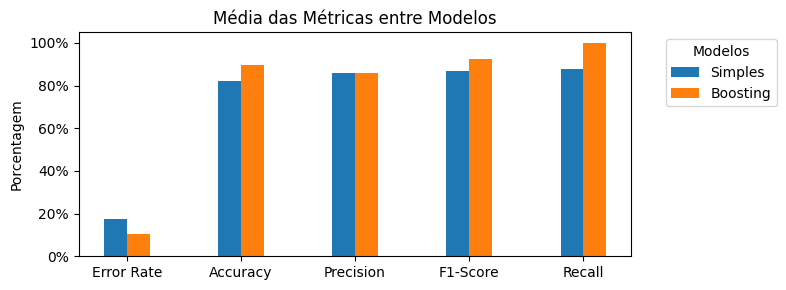

In [ ]:
fig, ax = plt.subplots(figsize=(8, 3))

average_simple_model = results_simple_model.iloc[:,: -1].mean(numeric_only=True)
average_boosting = results_boosting.iloc[:,: -1].mean(numeric_only=True)

bar_width = 0.2
index = np.arange(len(average_simple_model))

ax.bar(index, average_simple_model, bar_width, label='Simples')
ax.bar(index + bar_width, average_boosting, bar_width, label='Boosting')

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x*100:.0f}%'))

ax.set_ylabel('Porcentagem', fontsize=10)
ax.set_title('Média das Métricas entre Modelos', fontsize=12)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(average_simple_model.index)

plt.legend(fontsize=10, title="Modelos", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
results_simple_model.iloc[:,: -1].mean(numeric_only=True)

Error Rate    0.176445
Accuracy      0.823555
Precision     0.859918
F1-Score      0.866405
Recall        0.876111
dtype: float64

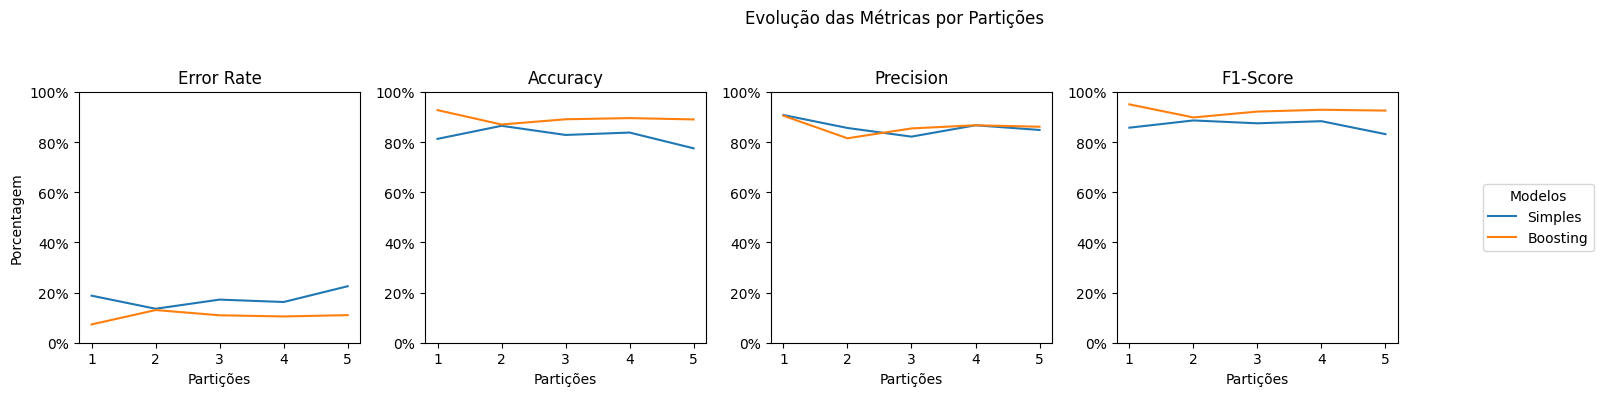

In [ ]:
def plot_scores(score, ax):
    results_simple_model.iloc[:, score].plot(kind='line', rot=0, ax=ax, label='Simples')
    results_boosting.iloc[:, score].plot(kind='line', rot=0, ax=ax, label='Boosting')

fig, axes = plt.subplots(1, 4, figsize=(18, 4))
for i in range(4):
    ax = axes[i]
    plot_scores(i, ax)
    ax.set_title(results_boosting.columns[i])
    ax.set_ylim(0, 1)
    ax.set_xlabel('Partições', fontsize=10)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x*100:.0f}%'))
    ax.set_xticks(range(len(results_simple_model.index)))
    ax.set_xticklabels(results_simple_model.index + 1)

axes[0].set_ylabel('Porcentagem', fontsize=10)
plt.xticks(range(len(results_simple_model.index)), results_simple_model.index + 1)
axes[3].legend(bbox_to_anchor=(1.3, 0.5), title='Modelos', loc="center left", fontsize=10, borderaxespad=0.0)

plt.suptitle('Evolução das Métricas por Partições', fontsize=12)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()

### Análise da Curva ROC

A curva ROC (Receiver Operating Characteristic) é uma representação gráfica do desempenho de um modelo de classificação binária. No gráfico abaixo, é possível visualizar a curva dos modelos Simples e com Boosting, que foram utilizados para classificar os resultados do dataset tic-tac-toe.

Ao observar a curva ROC abaixo, para os modelos Simples e com Boosting, podemos comparar visualmente o desempenho dos modelos na classificação dos resultados do dataset tic-tac-toe, levando em consideração a taxa de verdadeiro positivo e a taxa de falso positivo.

 Assim, é possível reparar que o modelo com Boosting tem a sua curva mais próxima ao canto superior esquerdo, evidenciando o seu desempenho superior ao modelo Simples, quando avaliada a capacidade de distinguir entre as classes positiva e negativa entre eles.


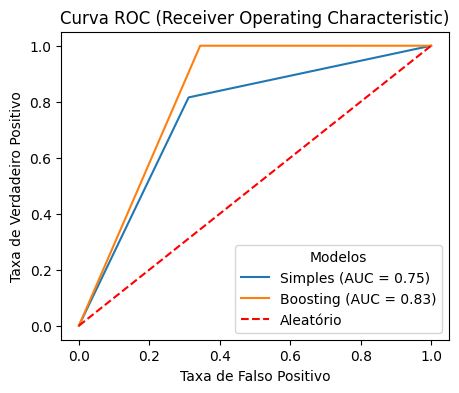

In [ ]:
plt.figure(figsize=(5, 4))

def plot_roc_curve(y_test, y_pred, model_name):
  # Plotting ROC curve for simple model
  fpr_simple, tpr_simple, thresholds_simple = roc_curve(y_test, y_pred)
  auc_simple = roc_auc_score(y_test, y_pred)
  plt.plot(fpr_simple, tpr_simple, label= model_name + ' (AUC = {:.2f})'.format(auc_simple))

plot_roc_curve(y_test, y_pred, 'Simples')
plot_roc_curve(y_test, boosted_pred, 'Boosting')

plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Aleatório')

plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC (Receiver Operating Characteristic)')
plt.legend(loc='lower right',  title='Modelos')

plt.show()

### Análise da Taxa de Aprendizado

A taxa de aprendizado abaixo mostra a evolução da acurácia ao longo das iterações para os modelos Simples e com Boosting.

Ao comparar os modelos Simples e com Boosting, podemos avaliar visualmente qual deles tem uma taxa de aprendizado melhor e como o desempenho da acuracia reage ao longo das iterações, o que nos fornece uma perspectiva sobre como os modelos Simples e com Boosting estão se ajustando aos dados e qual o impacto na sua performance durante o processo de treinamento.

Dado o contexto do gráfico, é possível que os modelos apresentados estejam se sobreajustando ao conjunto de treinamento, resultando em uma redução na acurácia à medida que mais iterações são realizadas.

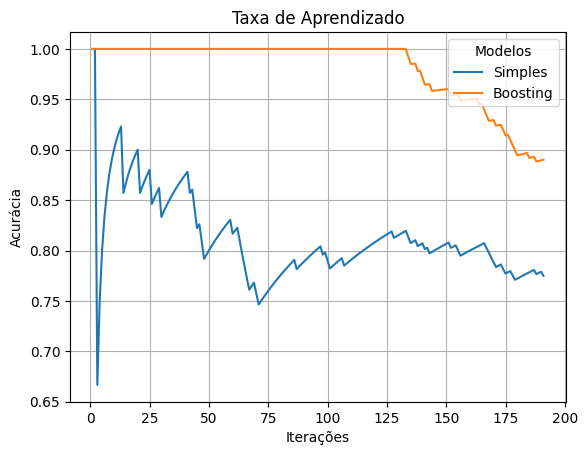

In [ ]:
def plot_learning_rate(y_test, y_pred, model_name):
    iterations = np.arange(1, len(y_pred) + 1)
    cumulative_accuracy = np.cumsum(y_pred == y_test) / iterations
    plt.plot(iterations, cumulative_accuracy, label=model_name)

plot_learning_rate(y_test, y_pred, 'Simples')
plot_learning_rate(y_test, boosted_pred, 'Boosting')
plt.xlabel('Iterações')
plt.ylabel('Acurácia')
plt.title('Taxa de Aprendizado')
plt.legend(loc='upper right', title='Modelos')
plt.grid(True)
plt.show()


## Conclusão

Neste trabalho, foi implementado o algoritmo de Boosting (AdaBoost) para classificação do dataset "tic-tac-toe". Foram treinados dois modelos: um modelo simples de árvore de decisão e um modelo com Boosting, utilizando um conjunto de classificadores de árvore de decisão e avaliado seu desempenho por meio de validação cruzada com 5 partições e outras métricas tradicionais.

Observou-se que o modelo com Boosting apresentou um desempenho superior em relação ao modelo simples de árvore de decisão. O Boosting conseguiu reduzir o número de falsos positivos e falsos negativos. Isso indica que o Boosting foi capaz de combinar os modelos fracos de forma a melhorar a classificação geral do conjunto de dados.

Em resumo, o algoritmo de Boosting mostrou-se eficaz para melhorar o desempenho da classificação do dataset "tic-tac-toe", superando o modelo simples de árvore de decisão. A técnica de Boosting pode ser uma opção interessante a ser considerada em problemas de classificação em que se deseja melhorar a acurácia e diminuir as taxas de erro do modelo.

## Referências

- [Scikit-learn Documentation](https://scikit-learn.org/)
- [UC Irvine Machine Learning Repository - Tic-Tac-Toe Endgame](https://archive.ics.uci.edu/dataset/101/tic+tac+toe+endgame)
- [Tic-Tac-Toe End Game Dataset UCI - Kaggle](https://www.kaggle.com/datasets/aungpyaeap/tictactoe-endgame-dataset-uci?datasetId=207741&searchQuery=bag)
